In [13]:
import numpy as np
import scipy
import numpy 
import matplotlib.pyplot as plt
from scipy import linalg, special, stats
from numpy import genfromtxt
import ML_support as ml
from scipy.optimize import fmin_l_bfgs_b

In [14]:
def logreg_obj_wrap(DTR, LTR, l):

    def logreg_obj(v):
        n = DTR.shape[1]
        w, b = v[0:-1], v[-1]
        w = w.reshape((len(w), 1))
        J = 0
        x = DTR
        for idx in range(n):
            if LTR[idx] == 0:
                c = 0
            else:
                c = 1

            J += (c * numpy.log1p(numpy.exp(numpy.dot(-w.T, x[:, idx]) - b)) + (1 - c) * numpy.log1p(numpy.exp(numpy.dot(w.T, x[:, idx]) + b)))

        return l/2 * ((numpy.linalg.norm(w))**2) + 1/n * J

    return logreg_obj

In [15]:
def logreg(DTR, LTR, DTE, LTE, l):
    logreg_obj = logreg_obj_wrap(DTR, LTR, l)
    v = numpy.zeros((DTR.shape[0]+1), dtype='int32')
    x, f, d = fmin_l_bfgs_b(logreg_obj, v, approx_grad=True)
    w, b = x[0:-1], x[-1]
    
    w = ml.mcol(w)
    S = numpy.zeros((DTE.shape[1]))
    for i in range(len(S)):
        S[i] = numpy.dot(w.T, DTE[:, i]) + b

    PL = numpy.zeros((len(LTE)))

    for i in range(len(S)):
        if(S[i] > 0):
            PL[i] = 1

    PL = PL == LTE
    correctPred = sum(PL)

    e = (len(LTE)-correctPred)/len(LTE)
    print(f'| lambda = {l} |{logreg_obj(x)}|   {round(e*100, 1)}%     |\n')
        

In [16]:
Data, label = ml.loadFile('../Train.txt')
(DTR, LTR), (DTE,LTE) = ml.split_db_2to1(Data, label, seed=42)
DTR_g, DTE_g = ml.gaussianize(DTR), ml.gaussianize(DTE)
DTR_z, DTE_z = ml.z_normalization(DTR), ml.z_normalization(DTE)


In [5]:
logreg(DTR_g, LTR, DTE_g, LTE, 0)

| l = 0 |[0.08436835]|   2.4%     |



In [6]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.1)

| l = 0.1 |[0.16196515]|   4.3%     |



In [7]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.01)

| l = 0.01 |[0.1075801]|   2.9%     |



In [8]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.001)

| l = 0.001 |[0.09114929]|   2.5%     |



In [9]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.00001)

| l = 1e-05 |[0.08455873]|   2.4%     |



In [11]:
logreg(DTR_g, LTR, DTE_g, LTE, 0.00000001)

| lambda = 1e-08 |[0.08436856]|   2.4%     |



In [14]:
logreg(DTR_z, LTR, DTE_z, LTE, 0)

| lambda = 0 |[0.07299565]|   2.2%     |



In [15]:
logreg(DTR_z, LTR, DTE_z, LTE, 0.1)
logreg(DTR_z, LTR, DTE_z, LTE, 0.01)
logreg(DTR_z, LTR, DTE_z, LTE, 0.001)
logreg(DTR_z, LTR, DTE_z, LTE, 0.00001)

| lambda = 0.1 |[0.14874581]|   4.1%     |

| lambda = 0.01 |[0.10062142]|   2.9%     |

| lambda = 0.001 |[0.08311847]|   2.5%     |

| lambda = 1e-05 |[0.07334328]|   2.2%     |



In [16]:
logreg(DTR_z, LTR, DTE_z, LTE, 0.0000001)

| lambda = 1e-07 |[0.07299922]|   2.2%     |



In [17]:
def logreg_mod1(DTR, LTR, DTE, LTE, l, app, ROC=False):
    logreg_obj = logreg_obj_wrap(DTR, LTR, l)
    v = numpy.zeros((DTR.shape[0]+1), dtype='int32')
    x, f, d = fmin_l_bfgs_b(logreg_obj, v, approx_grad=True)
    w, b = x[0:-1], x[-1]
    
    w = ml.mcol(w)
    S = numpy.zeros((DTE.shape[1]))
    for i in range(len(S)):
        S[i] = numpy.dot(w.T, DTE[:, i]) + b

    CM = ml.compute_optimal_B_decision(app, S, LTE)

    app_bayes_risk=ml.compute_Bayes_risk(CM, app)
    DCF = ml.compute_norm_Bayes(app_bayes_risk, app)

    minDCF= ml.compute_min_DCF(S, app, LTE)
    error = 1-(CM[0, 0]+CM[1,1])/(len(LTE))
    if(ROC == True):
        ml.plot_ROC(app, S, LTE)

    print("\-/ \-/ \-/ \-/ \-/ ")
    print("Logistic Regression error:", error)
    print(app,"DCF:", DCF, "minDCF:", minDCF)
    print('CM\n', CM)
    print("/-\ /-\ /-\ /-\ /-\ ")


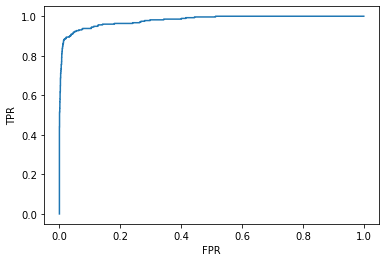

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.023513604299630453
[0.5, 1, 1] DCF: 0.16308996702779088 minDCF: 0.1262620281273131
CM
 [[2674.   42.]
 [  28.  233.]]
/-\ /-\ /-\ /-\ /-\ 


In [6]:
logreg_mod1(DTR_g, LTR, DTE_g, LTE, 0, [1/2, 1,1], True)

In [17]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.1, 1,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.029559959690964033
[0.1, 1, 1] DCF: 0.31755601911042325 minDCF: 0.2244788372249512
CM
 [[2694.   80.]
 [   8.  195.]]
/-\ /-\ /-\ /-\ /-\ 


In [18]:
logreg_mod1(DTR_z, LTR, DTE_z, LTE, 0, [0.9, 1,1], False)

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.03258313738663088
[0.9, 1, 1] DCF: 0.8124715698808965 minDCF: 0.5334149788035798
CM
 [[2629.   24.]
 [  73.  251.]]
/-\ /-\ /-\ /-\ /-\ 


In [18]:
def logreg_mod2(DTR, LTR, DTE, LTE, l):
    logreg_obj = logreg_obj_wrap(DTR, LTR, l)
    v = numpy.zeros((DTR.shape[0]+1), dtype='int32')
    x, f, d = fmin_l_bfgs_b(logreg_obj, v, approx_grad=True)
    w, b = x[0:-1], x[-1]
    
    w = ml.mcol(w)
    S = numpy.zeros((DTE.shape[1]))
    for i in range(len(S)):
        S[i] = numpy.dot(w.T, DTE[:, i]) + b

    return list(S)

In [19]:
def kfold(D, L, fold, l, app):
    error = 0
    N = int(D.shape[1]/fold) #numero di elementi per ogni fold
    numpy.random.seed(0) #imposto il seed del generatore di numeri casuali -> in tal modo genererò la stessa sequenza di numeri casuali aventi seed uguale
    indexes = numpy.random.permutation(D.shape[1]) #genero una sequenza di numeri casuali che vanno da 0 al num_di_campioni
    
    LTE_final = []
    llr_final = []
    for j in range(fold):
        test_indexes = indexes[(j*N):((j+1)*N)] #selezioni gli indici che identificano i campioni (casuali) del test set
        if(j > 0): #se il test set non è preso dalla prima fold (--> il test set è una fold intermedia o l'ultima fold)
            left_indexes = indexes[0:(j*N)] #allora prendo tutti gli indici che stanno a sinistra di tale fold
        else: #se il test set è preso dalla prima fold
            right_indexes = indexes[((j+1)*N):] #prendo tutti gli indici a destra della prima fold

        if(j == 0): #se il test set è preso dalla prima fold
            train_indexes = right_indexes #assegno agli indici di training quelli che stanno a destra della prima fold
        elif(j == fold-1): #se il test set è preso dall'ultima fold
            train_indexes = left_indexes #assegno agli indici di training quelli che stanno a sinistra dell'ultima fold
        else: #in questo caso il test set è preso da una fold intermedia
            train_indexes = numpy.hstack((left_indexes, right_indexes)) #pertanto assegno agli indici di training quelli appartenenti alle fold di sinistra e di destra

        DTR = D[:, train_indexes]  #definisco insieme di training e di testing
        LTR = L[train_indexes]
        DTE = D[:, test_indexes]
        LTE = L[test_indexes]
        LTE_final.extend(LTE)
        llr_final.extend(logreg_mod2(DTR, LTR, DTE, LTE, l))
        
    CM = ml.compute_optimal_B_decision(app, llr_final, LTE_final)
    sensitivity = (1-ml.compute_FNR(CM)) # TPR
    specificity = (1-ml.compute_FPR(CM)) # TNR
        
    app_bayes_risk=ml.compute_Bayes_risk(CM, app)
    DCF = ml.compute_norm_Bayes(app_bayes_risk, app)

    minDCF= ml.compute_min_DCF(llr_final, app, LTE_final)
    error = 1-(CM[0, 0]+CM[1,1])/(len(LTE_final))

    print("\-/ \-/ \-/ \-/ \-/ ")
    print("Logistic Regression error:", error)
    print(app,"DCF:", DCF, "minDCF:", minDCF)
    print('Sensitivity (TPR):', sensitivity, ' Specificity (TNR): ', specificity)
    print('CM\n', CM)
    print("/-\ /-\ /-\ /-\ /-\ ")

In [20]:
d_g = ml.gaussianize(Data)
d_z = ml.z_normalization(Data)

In [8]:
kfold(d_g, label, 5, 0, [0.5, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.021848739495798353
[0.5, 1, 1] DCF: 0.15979642840395203 minDCF: 0.12756260573566774
Sensitivity (TPR): 0.8489646772228989  Specificity (TNR):  0.991238894373149
CM
 [[8033.  124.]
 [  71.  697.]]
/-\ /-\ /-\ /-\ /-\ 


In [9]:
kfold(d_z, label, 5, 0, [0.5, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.02140056022408965
[0.5, 1, 1] DCF: 0.18338472572753955 minDCF: 0.11256422295782118
Sensitivity (TPR): 0.8221680876979294  Specificity (TNR):  0.9944471865745311
CM
 [[8059.  146.]
 [  45.  675.]]
/-\ /-\ /-\ /-\ /-\ 


In [10]:
kfold(d_z, label, 5, 0, [0.9, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.02789915966386558
[0.9, 1, 1] DCF: 0.8653166569072221 minDCF: 0.5450333243955258
Sensitivity (TPR): 0.9062119366626066  Specificity (TNR):  0.9787759131293189
CM
 [[7932.   77.]
 [ 172.  744.]]
/-\ /-\ /-\ /-\ /-\ 


In [11]:
kfold(d_g, label, 5, 0, [0.9, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.057591036414565866
[0.9, 1, 1] DCF: 0.7571115690902556 minDCF: 0.5245061761052722
Sensitivity (TPR): 0.9220462850182705  Specificity (TNR):  0.944471865745311
CM
 [[7654.   64.]
 [ 450.  757.]]
/-\ /-\ /-\ /-\ /-\ 


In [11]:
kfold(d_g, label, 5, 0, [0.1, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.050420168067226934
[0.1, 1, 1] DCF: 0.547359809684816 minDCF: 0.22719837003245266
Sensitivity (TPR): 0.46041412911084045  Specificity (TNR):  0.9991362290227048
CM
 [[8.097e+03 4.430e+02]
 [7.000e+00 3.780e+02]]
/-\ /-\ /-\ /-\ /-\ 


In [12]:
kfold(d_z, label, 5, 0, [0.1, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.029131652661064433
[0.1, 1, 1] DCF: 0.3148600772178488 minDCF: 0.2108267011193101
Sensitivity (TPR): 0.7040194884287454  Specificity (TNR):  0.9979022704837117
CM
 [[8087.  243.]
 [  17.  578.]]
/-\ /-\ /-\ /-\ /-\ 


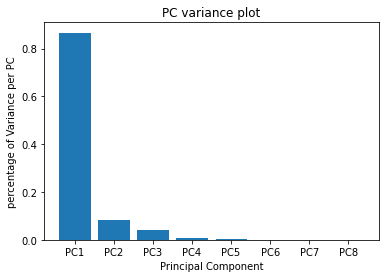

In [7]:
U = ml.PCAplot(Data)

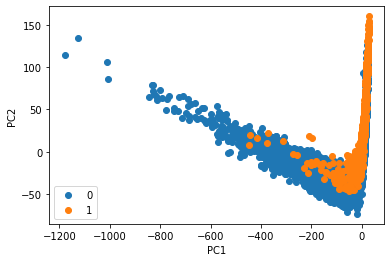

In [8]:
Data_pca = ml.PCA(Data, label, U, 5)

In [10]:
kfold(Data_pca, label, 5, 0, [0.1, 1, 1])

<ipython-input-2-273db2ebf8db>:15: RuntimeWarning: overflow encountered in exp
  J += (c * numpy.log1p(numpy.exp(numpy.dot(-w.T, x[:, idx]) - b)) + (1 - c) * numpy.log1p(numpy.exp(numpy.dot(w.T, x[:, idx]) + b)))
<ipython-input-2-273db2ebf8db>:15: RuntimeWarning: invalid value encountered in multiply
  J += (c * numpy.log1p(numpy.exp(numpy.dot(-w.T, x[:, idx]) - b)) + (1 - c) * numpy.log1p(numpy.exp(numpy.dot(w.T, x[:, idx]) + b)))


\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.09198879551820727
[0.1, 1, 1] DCF: 1.0 minDCF: 1.0
Sensitivity (TPR): 0.0  Specificity (TNR):  1.0
CM
 [[8104.  821.]
 [   0.    0.]]
/-\ /-\ /-\ /-\ /-\ 


In [21]:
kfold(d_z, label, 5, 0.1, [0.5, 1, 1])
kfold(d_g, label, 5, 0.1, [0.5, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.03966386554621848
[0.5, 1, 1] DCF: 0.4224244384511701 minDCF: 0.1666272381092088
Sensitivity (TPR): 0.5785627283800243  Specificity (TNR):  0.9990128331688055
CM
 [[8.096e+03 3.460e+02]
 [8.000e+00 4.750e+02]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.04112044817927174
[0.5, 1, 1] DCF: 0.42512321549455134 minDCF: 0.15794984927970487
Sensitivity (TPR): 0.5773447015834348  Specificity (TNR):  0.9975320829220138
CM
 [[8084.  347.]
 [  20.  474.]]
/-\ /-\ /-\ /-\ /-\ 


In [22]:
kfold(d_z, label, 5, 0.01, [0.5, 1, 1])
kfold(d_g, label, 5, 0.01, [0.5, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.02778711484593832
[0.5, 1, 1] DCF: 0.2681370863308055 minDCF: 0.14383492670797296
Sensitivity (TPR): 0.7356881851400731  Specificity (TNR):  0.9961747285291214
CM
 [[8073.  217.]
 [  31.  604.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.02577030812324932
[0.5, 1, 1] DCF: 0.21556293759686798 minDCF: 0.14748900709774154
Sensitivity (TPR): 0.7917174177831913  Specificity (TNR):  0.9927196446199408
CM
 [[8045.  171.]
 [  59.  650.]]
/-\ /-\ /-\ /-\ /-\ 


In [23]:
kfold(d_z, label, 5, 0.0001, [0.5, 1, 1])
kfold(d_g, label, 5, 0.0001, [0.5, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.022296918767507057
[0.5, 1, 1] DCF: 0.19312894010025575 minDCF: 0.11157705612662669
Sensitivity (TPR): 0.8124238733252132  Specificity (TNR):  0.9944471865745311
CM
 [[8059.  154.]
 [  45.  667.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.022184873949579798
[0.5, 1, 1] DCF: 0.16673440162179126 minDCF: 0.129660335251956
Sensitivity (TPR): 0.8416565164433618  Specificity (TNR):  0.991609081934847
CM
 [[8036.  130.]
 [  68.  691.]]
/-\ /-\ /-\ /-\ /-\ 


In [24]:
kfold(d_g, label, 5, 0.1, [0.1, 1, 1])
kfold(d_g, label, 5, 0.01, [0.1, 1, 1])
kfold(d_g, label, 5, 0.0001, [0.1, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.09042016806722686
[0.1, 1, 1] DCF: 0.9829476248477467 minDCF: 0.28648774818949274
Sensitivity (TPR): 0.01705237515225333  Specificity (TNR):  1.0
CM
 [[8104.  807.]
 [   0.   14.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.0654341736694678
[0.1, 1, 1] DCF: 0.7111127209852911 minDCF: 0.2675007184314027
Sensitivity (TPR): 0.2911084043848965  Specificity (TNR):  0.9997532082922014
CM
 [[8.102e+03 5.820e+02]
 [2.000e+00 2.390e+02]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.05120448179271708
[0.1, 1, 1] DCF: 0.5558859972609427 minDCF: 0.2301720447820237
Sensitivity (TPR): 0.4518879415347138  Specificity (TNR):  0.9991362290227048
CM
 [[8.097e+03 4.500e+02]
 [7.000e+00 3.710e+02]]
/-\ /-\ /-\ /-\ /-\ 


In [25]:
kfold(d_z, label, 5, 0.1, [0.1, 1, 1])
kfold(d_z, label, 5, 0.01, [0.1, 1, 1])
kfold(d_z, label, 5, 0.0001, [0.1, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.0649859943977591
[0.1, 1, 1] DCF: 0.7063480779104288 minDCF: 0.2783198745179896
Sensitivity (TPR): 0.29476248477466505  Specificity (TNR):  0.9998766041461007
CM
 [[8.103e+03 5.790e+02]
 [1.000e+00 2.420e+02]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.041568627450980444
[0.1, 1, 1] DCF: 0.45113569275424353 minDCF: 0.24883638160671323
Sensitivity (TPR): 0.556638246041413  Specificity (TNR):  0.9991362290227048
CM
 [[8.097e+03 3.640e+02]
 [7.000e+00 4.570e+02]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.03014005602240899
[0.1, 1, 1] DCF: 0.3262521748331375 minDCF: 0.21100570777216526
Sensitivity (TPR): 0.6881851400730816  Specificity (TNR):  0.998395853899309
CM
 [[8091.  256.]
 [  13.  565.]]
/-\ /-\ /-\ /-\ /-\ 


In [26]:
kfold(d_g, label, 5, 0.1, [0.9, 1, 1])
kfold(d_g, label, 5, 0.01, [0.9, 1, 1])
kfold(d_g, label, 5, 0.0001, [0.9, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.11731092436974788
[0.9, 1, 1] DCF: 0.8553980951648065 minDCF: 0.6057206377987503
Sensitivity (TPR): 0.9183922046285018  Specificity (TNR):  0.8790720631786773
CM
 [[7124.   67.]
 [ 980.  754.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.0765266106442577
[0.9, 1, 1] DCF: 0.886353921553303 minDCF: 0.532726804886055
Sensitivity (TPR): 0.9098660170523751  Specificity (TNR):  0.9248519249753209
CM
 [[7495.   74.]
 [ 609.  747.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.05882352941176472
[0.9, 1, 1] DCF: 0.7909854594293673 minDCF: 0.5233756235924457
Sensitivity (TPR): 0.9183922046285018  Specificity (TNR):  0.9434846989141165
CM
 [[7646.   67.]
 [ 458.  754.]]
/-\ /-\ /-\ /-\ /-\ 


In [27]:
kfold(d_z, label, 5, 0.1, [0.9, 1, 1])
kfold(d_z, label, 5, 0.01, [0.9, 1, 1])
kfold(d_z, label, 5, 0.0001, [0.9, 1, 1])

\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.05647058823529416
[0.9, 1, 1] DCF: 1.1243983512750808 minDCF: 0.6162927015786253
Sensitivity (TPR): 0.8806333739342266  Specificity (TNR):  0.9499012833168805
CM
 [[7698.   98.]
 [ 406.  723.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.043249299719888
[0.9, 1, 1] DCF: 1.0122880326763044 minDCF: 0.567317623633327
Sensitivity (TPR): 0.8915956151035322  Specificity (TNR):  0.9633514313919053
CM
 [[7807.   89.]
 [ 297.  732.]]
/-\ /-\ /-\ /-\ /-\ 
\-/ \-/ \-/ \-/ \-/ 
Logistic Regression error: 0.028459383753501433
[0.9, 1, 1] DCF: 0.8659336361767187 minDCF: 0.5511031679518273
Sensitivity (TPR): 0.9062119366626066  Specificity (TNR):  0.9781589338598223
CM
 [[7927.   77.]
 [ 177.  744.]]
/-\ /-\ /-\ /-\ /-\ 
